<a href="https://colab.research.google.com/github/aneekbsws/lunar-lander/blob/main/Lunar_Lander.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Importing Libraries

In [35]:
!pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
 !pip install pyvirtualdisplay

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
!pip install gym pyvirtualdisplay
!apt-get install -y xvfb python-opengl ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-2build1).
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
xvfb is already the newest version (2:1.20.13-1ubuntu1~20.04.6).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.


In [38]:
!pip install Xvfb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement Xvfb (from versions: none)
ERROR: No matching distribution found for Xvfb


In [39]:
import time
from collections import deque, namedtuple # deque will be our data structure for our memory buffer.
import gym # The gym toolkit is a collection of environments that can be used to test reinforcement learning algorithms. 
import numpy as np
import PIL.Image
import tensorflow as tf

from pyvirtualdisplay import Display # PIL.Image and pyvirtualdisplay are needed to render the Lunar Lander environment.
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

In [40]:
# Setting up a virtual display to render the Lunar Lander Environment
Display(visible=0, size = (840,480)).start()

# Set random seed for tensorflow
tf.random.set_seed(0)

#2. Setting the hyper parameters

In [41]:
MEMORY_SIZE = 100_000 # Size of the memory buffer
GAMMA = 0.995 # Discount factor
ALPHA = 1e-3 # Learning Rate
NUM_STEPS_FOR_UPDATE = 4 # Perform a learning update every C time steps

#3. Lunar Landing

**OpenAI's gym**
  The Gym library provides a wide variety of environments for reinforcement learning. To put it simply, an environment represents a problem or task to be solved.
  Goal is to land the lunar lander safely between two poles (the landing pad). 
  
  The agent has four discrete actions available to it -
  

*   Do-nothing (0)
*   Fire right engine (1)
*  Fire main engine (2)
*  Fire left engine (3)


Agent's observation space has 8 variables: 
* x,y coordinates. Launding pad is at (0,0).
* Linear velocities (dx,dy)
* angle (theta)
* angle velocity (dtheta)
* two booleans (l and r) to check whether any of the legs are touching the surface.

Rewards - 
* Landing on the landing pad and coming to rest is about 100-140 points.
* If the lander moves away from the landing pad, it loses reward.
* If the lander crashes, it receives -100 points.
* If the lander comes to rest, it receives +100 points.
* Each leg with ground contact is +10 points.
* Firing the main engine is -0.3 points each frame.
* Firing the side engine is -0.03 points each frame.

Episode finishes if - 
* lander crashes, or
* lander gets to outside of viewport, or


**3.1 Load the environment**

In [42]:
env = gym.make('LunarLander-v2')

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


After this we reset the environment to its initial state. The initial state is the rover starting at the top centre of the screen, which can be rendered using .render() function

Python Imaging Library (expansion of PIL) is the de facto image processing package for Python language. It incorporates lightweight image processing tools that aids in editing, creating and saving images

/usr/local/lib/python3.9/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


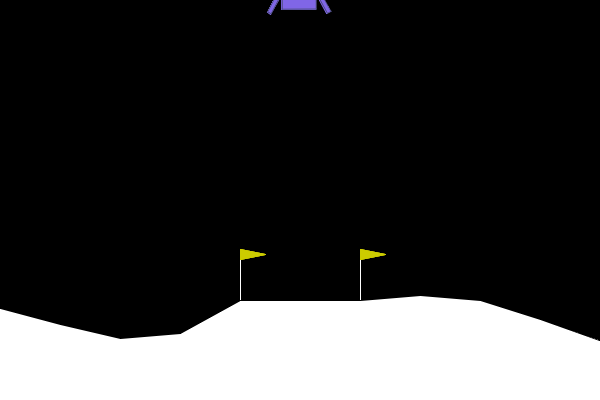

In [43]:
env.reset()
PIL.Image.fromarray(env.render(mode='rgb_array'))

In [44]:
state_size = env.observation_space.shape # Number of states
num_actions = env.action_space.n

print('Shape of state = ',state_size)
print('Number of permitted actions = ',num_actions)

Shape of state =  (8,)
Number of permitted actions =  4


#4. Interacting with the Gym environment.#

In the standard “agent-environment loop” formalism, an agent interacts with the environment in discrete time steps. At each time step t, the agent uses a policy pi, to select an action a, based on its observation of the environment's state s.The agent receives a numerical reward R(s)and on the next time step, moves to a new state S_t+1. 

In [45]:
initial_state = env.reset()

In [46]:
# Selecting an action
action = 0

# Run a single time step
next_state, reward, done, info = env.step(action)

with np.printoptions(formatter={'float': '{:.3f}'.format}):
    print("Initial State:", initial_state)
    print("Action:", action)
    print("Next State:", next_state)
    print("Reward Received:", reward)
    print("Episode Terminated:", done)
    print("Info:", info)

Initial State: [-0.002 1.400 -0.204 -0.493 0.002 0.046 0.000 0.000]
Action: 0
Next State: [-0.004 1.388 -0.204 -0.518 0.005 0.046 0.000 0.000]
Reward Received: -1.4285454669162618
Episode Terminated: False
Info: {}


#5. Deep Q Learning#

Cases where both the action and states are discrete, we use the Bellman's equation : 

  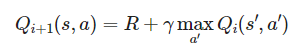


Here the agent explores the states and the actions to gradually arrive at an optimal Q(s,a). However, continuous sets of states make it practically impossible to explore all the states and actions. 

This is solved in Deep Q Learning by estimating Q such that Q (s,a) ~ Q*(s,a).
The network is trained by updating the weights at each iteration to minimize the mean squared error. 
To avoid instabilities, two methods are used - 
* Target Network
* Experience Replay

**5.1 Target Network**

At each iteration we are looking forward to minimize the following error  :

  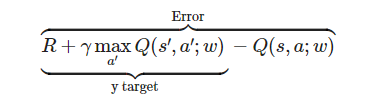

However, to have a moving y as target will lead to oscillations and instabilities. Hence we use a different Deep Q network called target network to generate Y targets. 

In practice, we will use the following algorithm: every C time steps we will use the Q_hat Network to generate the targets and update the weights of the target Q_hat Network using the weights of the Q Network. We will update the weights of the the target Q_hat Network using a soft update. By using the soft update, we are ensuring that the target values y change slowly, which greatly improves the stability of our learning algorithm.

In [47]:
q_network = Sequential([
    Input(shape=state_size),
    Dense(units=64,activation='relu'),
    Dense(units=64,activation='relu'),
    Dense(units=num_actions, activation='linear')
])

target_q_network = Sequential([
    Input(shape=state_size),
    Dense(units=64,activation='relu'),
    Dense(units=64,activation='relu'),
    Dense(units=num_actions, activation='linear')
])

optimizier = Adam(learning_rate=ALPHA)

**5.2 Experience Replay**

If the agent tries to learn from consecutive replays, there will be strong correlation and it can run into problems. Experience replay consists of storing the agent's experiences (i.e the states, actions, and rewards the agent receives) in a memory buffer and then sampling a random mini-batch of experiences from the buffer to do the learning. 

In [49]:
experience = namedtuple("Experience",field_names=["state","action","reward","next_state","done"])

#6. Deep Q Learning with Experience Replays#

In [50]:
def compute_loss(experiences,gamma,q_network,target_q_network):
  state, action, reward,next_state,done = experiences
  max_qsa = tf.reduce_max(target_q_network(next_state), axis=-1)

  y_targets = reward + (gamma*max_qsa*(1-done))

  q_values = q_network(state)
  q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(action, tf.int32)], axis=1))
  
  loss = MSE(y_targets, q_values)
  return loss

In [51]:
def update_target_network(q_network, target_q_network):
    for target_weights, q_net_weights in zip(target_q_network.weights, q_network.weights):
        target_weights.assign(TAU * q_net_weights + (1.0 - TAU) * target_weights)

In [52]:
@tf.function
def agent_learn(experiences, gamma):
  with tf.GradientTape() as tape:
    loss = compute_loss(experiences, gamma,q_network, target_q_network)

  gradients = tape.gradient(loss,q_network.trainable_variables)

  optimizier.apply_gradients(zip(gradients, q_network.trainable_variables))
  update_target_network(q_network,target_q_network)

#7. Train the agent#

In [56]:
import random

In [57]:
def get_action(q_values, epsilon=0):
    if random.random() > epsilon:
        return np.argmax(q_values.numpy()[0])
    else:
        return random.choice(np.arange(4))

In [60]:

SEED = 0              # seed for pseudo-random number generator
MINIBATCH_SIZE = 64   # mini-batch size
TAU = 1e-3            # soft update parameter
E_DECAY = 0.995       # ε decay rate for ε-greedy policy
E_MIN = 0.01          # minimum ε value for ε-greedy policy

def get_experiences(memory_buffer):
    experiences = random.sample(memory_buffer, k=MINIBATCH_SIZE)
    states = tf.convert_to_tensor(np.array([e.state for e in experiences if e is not None]),dtype=tf.float32)
    actions = tf.convert_to_tensor(np.array([e.action for e in experiences if e is not None]), dtype=tf.float32)
    rewards = tf.convert_to_tensor(np.array([e.reward for e in experiences if e is not None]), dtype=tf.float32)
    next_states = tf.convert_to_tensor(np.array([e.next_state for e in experiences if e is not None]),dtype=tf.float32)
    done_vals = tf.convert_to_tensor(np.array([e.done for e in experiences if e is not None]).astype(np.uint8),
                                     dtype=tf.float32)
    return (states, actions, rewards, next_states, done_vals)


def check_update_conditions(t, num_steps_upd, memory_buffer):
    if (t + 1) % num_steps_upd == 0 and len(memory_buffer) > MINIBATCH_SIZE:
        return True
    else:
        return False
    
    
def get_new_eps(epsilon):
    return max(E_MIN, E_DECAY*epsilon)

In [61]:
start = time.time()

num_episodes = 2000
max_num_timesteps = 1000

total_point_history = []

num_p_av = 100    # number of total points to use for averaging
epsilon = 1.0     # initial ε value for ε-greedy policy

# Create a memory buffer D with capacity N
memory_buffer = deque(maxlen=MEMORY_SIZE)

# Set the target network weights equal to the Q-Network weights
target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):
    
    # Reset the environment to the initial state and get the initial state
    state = env.reset()
    total_points = 0
    
    for t in range(max_num_timesteps):
        
        # From the current state S choose an action A using an ε-greedy policy
        state_qn = np.expand_dims(state, axis=0)  # state needs to be the right shape for the q_network
        q_values = q_network(state_qn)
        action = get_action(q_values, epsilon)
        
        # Take action A and receive reward R and the next state S'
        next_state, reward, done, _ = env.step(action)
        
        # Store experience tuple (S,A,R,S') in the memory buffer.
        # We store the done variable as well for convenience.
        memory_buffer.append(experience(state, action, reward, next_state, done))
                # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
        update = check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)
        
        if update:
            # Sample random mini-batch of experience tuples (S,A,R,S') from D
            experiences = get_experiences(memory_buffer)
            
            # Set the y targets, perform a gradient descent step,
            # and update the network weights.
            agent_learn(experiences, GAMMA)
        
        state = next_state.copy()
        total_points += reward
        
        if done:
            break
            
    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])
    
    # Update the ε value
    epsilon = get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

    # We will consider that the environment is solved if we get an
    # average of 200 points in the last 100 episodes.
    if av_latest_points >= 200.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('lunar_lander_model.h5')
        break
        
tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode 100 | Total point average of the last 100 episodes: -146.12
Episode 200 | Total point average of the last 100 episodes: -118.40
Episode 300 | Total point average of the last 100 episodes: -11.90
Episode 400 | Total point average of the last 100 episodes: 143.24
Episode 500 | Total point average of the last 100 episodes: 186.56
Episode 600 | Total point average of the last 100 episodes: 166.57
Episode 700 | Total point average of the last 100 episodes: 198.48
Episode 701 | Total point average of the last 100 episodes: 198.15

Episode 702 | Total point average of the last 100 episodes: 200.79

Environment solved in 702 episodes!

Total Runtime: 1478.86 s (24.65 min)


In [70]:
import base64
import random
from itertools import zip_longest
import matplotlib.pyplot as plt
import imageio
import pandas as pd
import IPython
import matplotlib.ticker as mticker

def plot_history(reward_history, rolling_window=20, lower_limit=None,
                 upper_limit=None, plot_rw=True, plot_rm=True):
    
    if lower_limit is None or upper_limit is None:
        rh = reward_history
        xs = [x for x in range(len(reward_history))]
    else:
        rh = reward_history[lower_limit:upper_limit]
        xs = [x for x in range(lower_limit,upper_limit)]
    
    df = pd.DataFrame(rh)
    rollingMean = df.rolling(rolling_window).mean()

    plt.figure(figsize=(10,7), facecolor='white')
    
    if plot_rw:
        plt.plot(xs, rh, linewidth=1, color='cyan')
    if plot_rm:
        plt.plot(xs, rollingMean, linewidth=2, color='magenta')

    text_color = 'black'
        
    ax = plt.gca()
    ax.set_facecolor('black')
    plt.grid()
#     plt.title("Total Point History", color=text_color, fontsize=40)
    plt.xlabel('Episode', color=text_color, fontsize=30)
    plt.ylabel('Total Points', color=text_color, fontsize=30)
    yNumFmt = mticker.StrMethodFormatter('{x:,}')
    ax.yaxis.set_major_formatter(yNumFmt)
    ax.tick_params(axis='x', colors=text_color)
    ax.tick_params(axis='y', colors=text_color)
    plt.show()
    
    
def display_table(initial_state, action, next_state, reward, done):

    action_labels = ["Do nothing", "Fire right engine", "Fire main engine", "Fire left engine"]
    
    # Do not use column headers
    column_headers = None

    with np.printoptions(formatter={'float': '{:.3f}'.format}):
        table_info = [("Initial State:", [f"{initial_state}"]),
                      ("Action:", [f"{action_labels[action]}"]),
                      ("Next State:", [f"{next_state}"]),
                      ("Reward Received:", [f"{reward:.3f}"]),
                      ("Episode Terminated:", [f"{done}"])]

    # Generate table  
    row_labels, data = zip_longest(*table_info)
    table = SimpleTable(data, column_headers, row_labels)

    return table


def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="840" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    return IPython.display.HTML(tag)
        
        
def create_video(filename, env, q_network, fps=30):
    with imageio.get_writer(filename, fps=fps) as video:
        done = False
        state = env.reset()
        frame = env.render(mode="rgb_array")
        video.append_data(frame)
        while not done:    
            state = np.expand_dims(state, axis=0)
            q_values = q_network(state)
            action = np.argmax(q_values.numpy()[0])
            state, _, done, _ = env.step(action)
            frame = env.render(mode="rgb_array")
            video.append_data(frame)

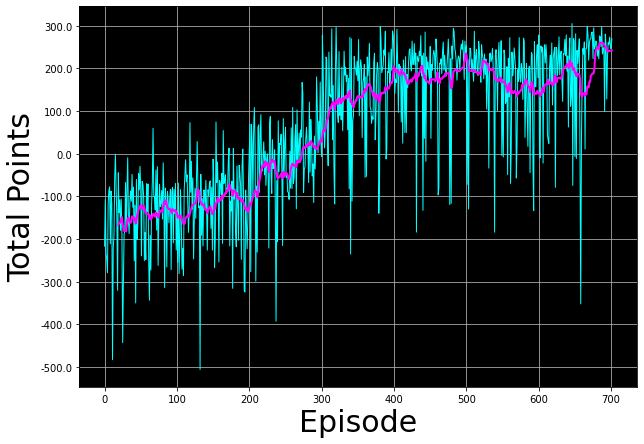

In [71]:
plot_history(total_point_history)

In [72]:
# Suppress warnings from imageio
import logging
logging.getLogger().setLevel(logging.ERROR)

In [74]:
filename = "lunar_lander.mp4"

create_video(filename, env, q_network)
embed_mp4(filename)

/usr/local/lib/python3.9/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
